# Intro

## pip installations

In [1]:
# pip install feature_engine

In [2]:
# pip install xgboost

In [3]:
# pip install shap

In [4]:
# pip install matplotlib

In [5]:
# pip install seaborn

In [59]:
# pip freeze > requirements.txt

## Libraries and paths

In [7]:
import os
# import sys
# import copy
import math
import pickle
# import random
# import pymusickit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import shap
import statsmodels.api as sm
from xgboost import XGBRegressor
from feature_engine.outliers import Winsorizer
# from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import make_scorer #, r2_score, roc_curve
from sklearn.model_selection import PredefinedSplit, GridSearchCV #, train_test_split, KFold

In [8]:
# Set paths.
DATA_LOC = r'C:\Users\enriq\OneDrive\Desktop\Work\Code\Music\Data'
TRACKS_LOC = os.path.join(DATA_LOC, 'Tracks')
DATA_FNAMES = [
    'my_playlist_tracks.csv',
    'spotify_sample_tracks.csv',
    'global_top_artist_tracks.csv',
    'global_top_artist_tracks_rand.csv'
]
DATA_PATHS = [os.path.join(TRACKS_LOC, fname) for fname in DATA_FNAMES]
# User options.
EXPORT_DATA = True
# Other.
NUM_FOLDS = 5
NUM_TRAIN_SPLITS = NUM_FOLDS - 1
RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

## Read in data

In [9]:
tracks_orig = pd.DataFrame()
for path in DATA_PATHS:
    tracks_new = pd.read_csv(path)
    tracks_orig = pd.concat([tracks_orig, tracks_new], ignore_index = True)

tracks = tracks_orig.copy()
tracks = tracks.drop_duplicates(ignore_index = True)
tracks

,name,id,artist,artist_id,album,popularity,is_top_10,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,LUMBERJACK,0BiK5BbYNFLb88CCOxBFJe,"Tyler, The Creator",4V8LLVI7PbaPR0K2TGSxFF,CALL ME IF YOU GET LOST,60,0,True,0.39,0.76,...,-6.34,1.00,0.56,0.12,0.00,0.53,0.43,170.69,138312.00,4.00
1,911 / Mr. Lonely (feat. Frank Ocean & Steve Lacy),4bEcoz1OcfMgUbp2ft8ieQ,"Tyler, The Creator",4V8LLVI7PbaPR0K2TGSxFF,Flower Boy,72,0,True,0.48,0.61,...,-7.04,1.00,0.30,0.05,0.00,0.31,0.30,90.03,255653.00,4.00
2,Rusty (feat. Domo Genesis & Earl Sweatshirt),4oQkcfukOHfKsmeoeXQLWC,"Tyler, The Creator",4V8LLVI7PbaPR0K2TGSxFF,Wolf,56,0,True,0.50,0.68,...,-5.65,1.00,0.25,0.01,0.00,0.40,0.36,81.28,309693.00,4.00
3,ARE WE STILL FRIENDS?,5TxRUOsGeWeRl3xOML59Ai,"Tyler, The Creator",4V8LLVI7PbaPR0K2TGSxFF,IGOR,79,1,True,0.22,0.50,...,-8.03,1.00,0.04,0.13,0.00,0.11,0.31,187.31,265480.00,3.00
4,48,2wK7y55bzry7tUDmDqYaz7,"Tyler, The Creator",4V8LLVI7PbaPR0K2TGSxFF,Wolf,57,0,True,0.56,0.89,...,-8.08,1.00,0.27,0.13,0.00,0.89,0.54,119.91,247293.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44064,On My Love - Slowed Down,2L9T1gjyWIksRqIgbu17nh,Zara Larsson,1Xylc3o4UrD53lo9CvFvVg,On My Love (Sped Up),14,0,False,0.48,0.65,...,-5.82,0.00,0.05,0.25,0.00,0.07,0.20,109.45,250776.00,4.00
44065,On My Love - Nightcore Remix,2Da5psDjUOUPPOCNkmTgSb,Zara Larsson,1Xylc3o4UrD53lo9CvFvVg,On My Love (Sped Up),25,0,False,0.49,0.68,...,-4.98,0.00,0.04,0.11,0.00,0.25,0.38,132.16,208051.00,4.00
44066,On My Love,0K6iKgHPPhAb4Acmg9aD77,Zara Larsson,1Xylc3o4UrD53lo9CvFvVg,On My Love (Sped Up),56,0,False,0.49,0.69,...,-4.99,0.00,0.05,0.07,0.00,0.09,0.32,123.07,222912.00,4.00
44067,F1000,49z4lZi0V1CAN1hzYO1QWy,DENNIS,6xlRSRMLgZbsSNd0BMobwy,F1000,62,1,False,0.56,0.69,...,-2.47,0.00,0.36,0.47,0.00,0.10,0.72,86.13,157514.00,3.00


# EDA

## Data exploration

In [10]:
tracks.columns

Index(['name', 'id', 'artist', 'artist_id', 'album', 'popularity', 'is_top_10',
       'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

In [11]:
# Set features.
TRGT_FEATURE = 'popularity' # or 'is_top_10' for binary classification
NON_PREDICTORS = [
    'TEST',
    'name',
    'id',
    'artist',
    'artist_id',   # keep ?
    'album',
    'popularity',   # potential target
    'is_top_10' # potential target
]
catg_preds = [
    'explicit', # binary
    'key',  # ordinal ?
    'mode', # binary
    'time_signature',   # categorical ??
]
numeric_preds = [
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
]
preds = catg_preds + numeric_preds

### Univariate

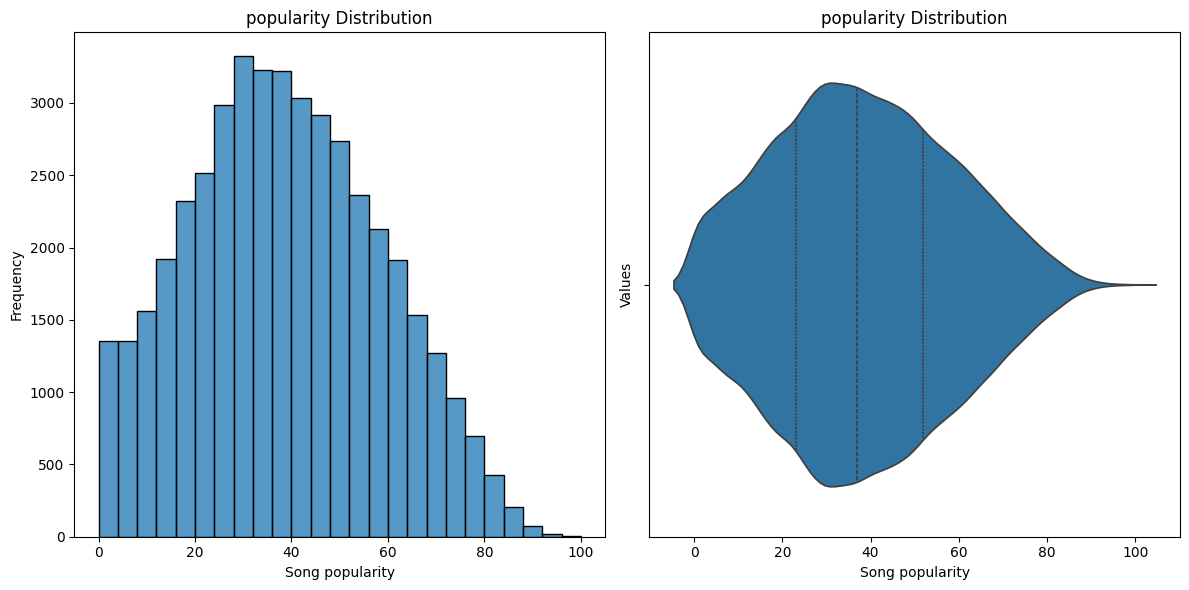

In [12]:
# Plot distribution of target feature.
fig, axs = plt.subplots(1, 2, figsize = (12, 6))
sns.histplot(data = tracks, x = TRGT_FEATURE, bins = 25, ax = axs[0])
axs[0].set_title(TRGT_FEATURE + ' Distribution')
axs[0].set_xlabel('Song ' + TRGT_FEATURE)
axs[0].set_ylabel('Frequency')
sns.violinplot(data = tracks, x = TRGT_FEATURE, inner = 'quart', ax = axs[1])
axs[1].set_title(TRGT_FEATURE + ' Distribution')
axs[1].set_xlabel('Song ' + TRGT_FEATURE)
axs[1].set_ylabel('Values')
plt.tight_layout()
plt.show()

In [13]:
# Check value counts.
_ = [print(tracks[col].value_counts().sort_index(), '\n') for col in tracks[preds]]

explicit
False    31935
True     12134
Name: count, dtype: int64 

key
0.00     5149
1.00     4997
2.00     4255
3.00     1332
4.00     3164
5.00     3657
6.00     2982
7.00     4706
8.00     3041
9.00     4201
10.00    2989
11.00    3566
Name: count, dtype: int64 

mode
0.00    16707
1.00    27332
Name: count, dtype: int64 

time_signature
0.00       26
1.00      338
3.00     3219
4.00    39718
5.00      738
Name: count, dtype: int64 

danceability
0.00    26
0.06     1
0.06     1
0.06     1
0.07     1
        ..
0.98     2
0.98     1
0.98     3
0.99     2
0.99     2
Name: count, Length: 903, dtype: int64 

energy
0.00     2
0.00     1
0.00     1
0.00     1
0.00     1
        ..
0.99    26
1.00    13
1.00    14
1.00     9
1.00     3
Name: count, Length: 1350, dtype: int64 

loudness
-60.00    2
-40.78    1
-40.56    1
-40.44    1
-39.73    1
         ..
0.92      1
1.05      1
1.26      1
1.38      1
1.74      1
Name: count, Length: 12226, dtype: int64 

speechiness
0.00    26
0.02   

In [14]:
tracks.describe()

,popularity,is_top_10,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,44069.00,44069.00,44039.00,44039.00,44039.00,44039.00,44039.00,44039.00,44039.00,44039.00,44039.00,44039.00,44039.00,44039.00,44039.00
mean,38.19,0.11,0.61,0.65,5.23,-7.40,0.62,0.11,0.25,0.06,0.23,0.49,121.09,222656.43,3.92
std,19.86,0.31,0.17,0.21,3.61,3.85,0.49,0.12,0.28,0.20,0.21,0.24,29.34,90291.89,0.40
min,0.00,0.00,0.00,0.00,0.00,-60.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2988.00,0.00
25%,23.00,0.00,0.49,0.52,2.00,-8.69,0.00,0.04,0.03,0.00,0.10,0.29,97.55,178040.00,4.00
50%,37.00,0.00,0.62,0.67,5.00,-6.58,1.00,0.06,0.13,0.00,0.14,0.48,120.04,213387.00,4.00
75%,52.00,0.00,0.73,0.81,8.00,-5.03,1.00,0.12,0.41,0.00,0.28,0.68,139.97,254320.00,4.00
max,100.00,1.00,0.99,1.00,11.00,1.74,1.00,0.97,1.00,1.00,1.00,0.99,244.08,4471880.00,5.00


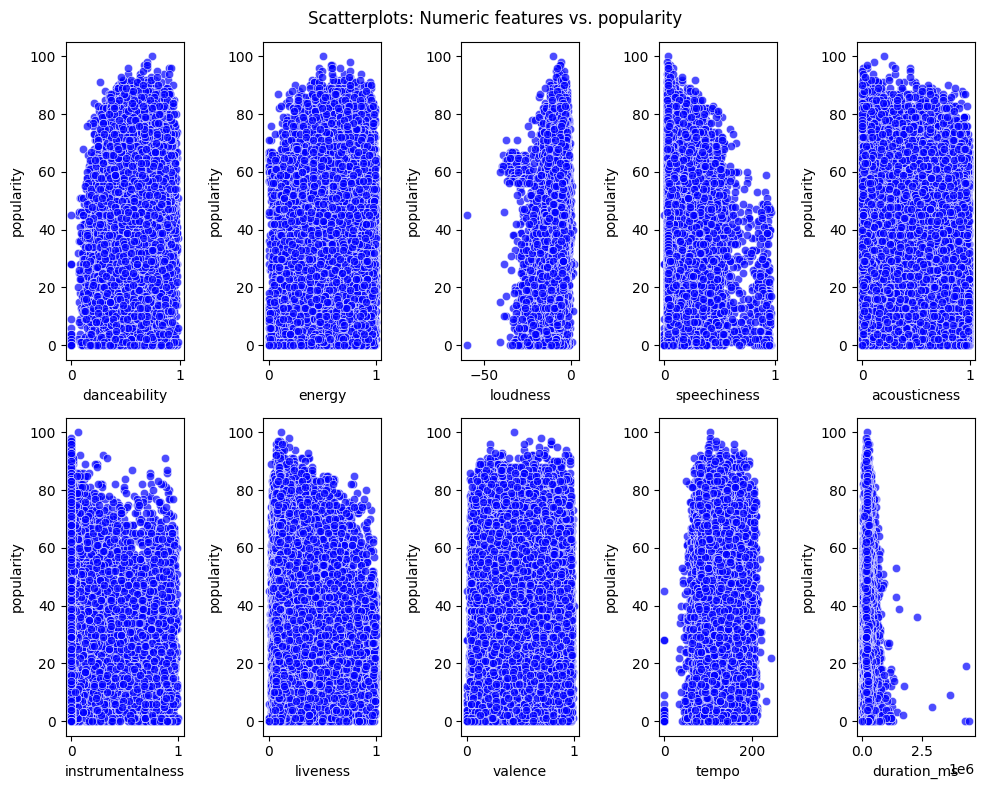

In [15]:
# Create subplots for each feature
ncols = 5
fig, axes = plt.subplots(2, ncols, figsize = (10, 8))
fig.suptitle('Scatterplots: Numeric features vs. ' + TRGT_FEATURE)
for i, feature in enumerate(numeric_preds):
    row, col = divmod(i, ncols)
    sns.scatterplot(
        data = tracks, x = feature, y = TRGT_FEATURE, 
        color = 'b', alpha = 0.7, ax = axes[row, col],
    )
    # axes[row, col].set_title(feature + ' vs. ' + TRGT_FEATURE)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel(TRGT_FEATURE)
plt.tight_layout()
plt.show()

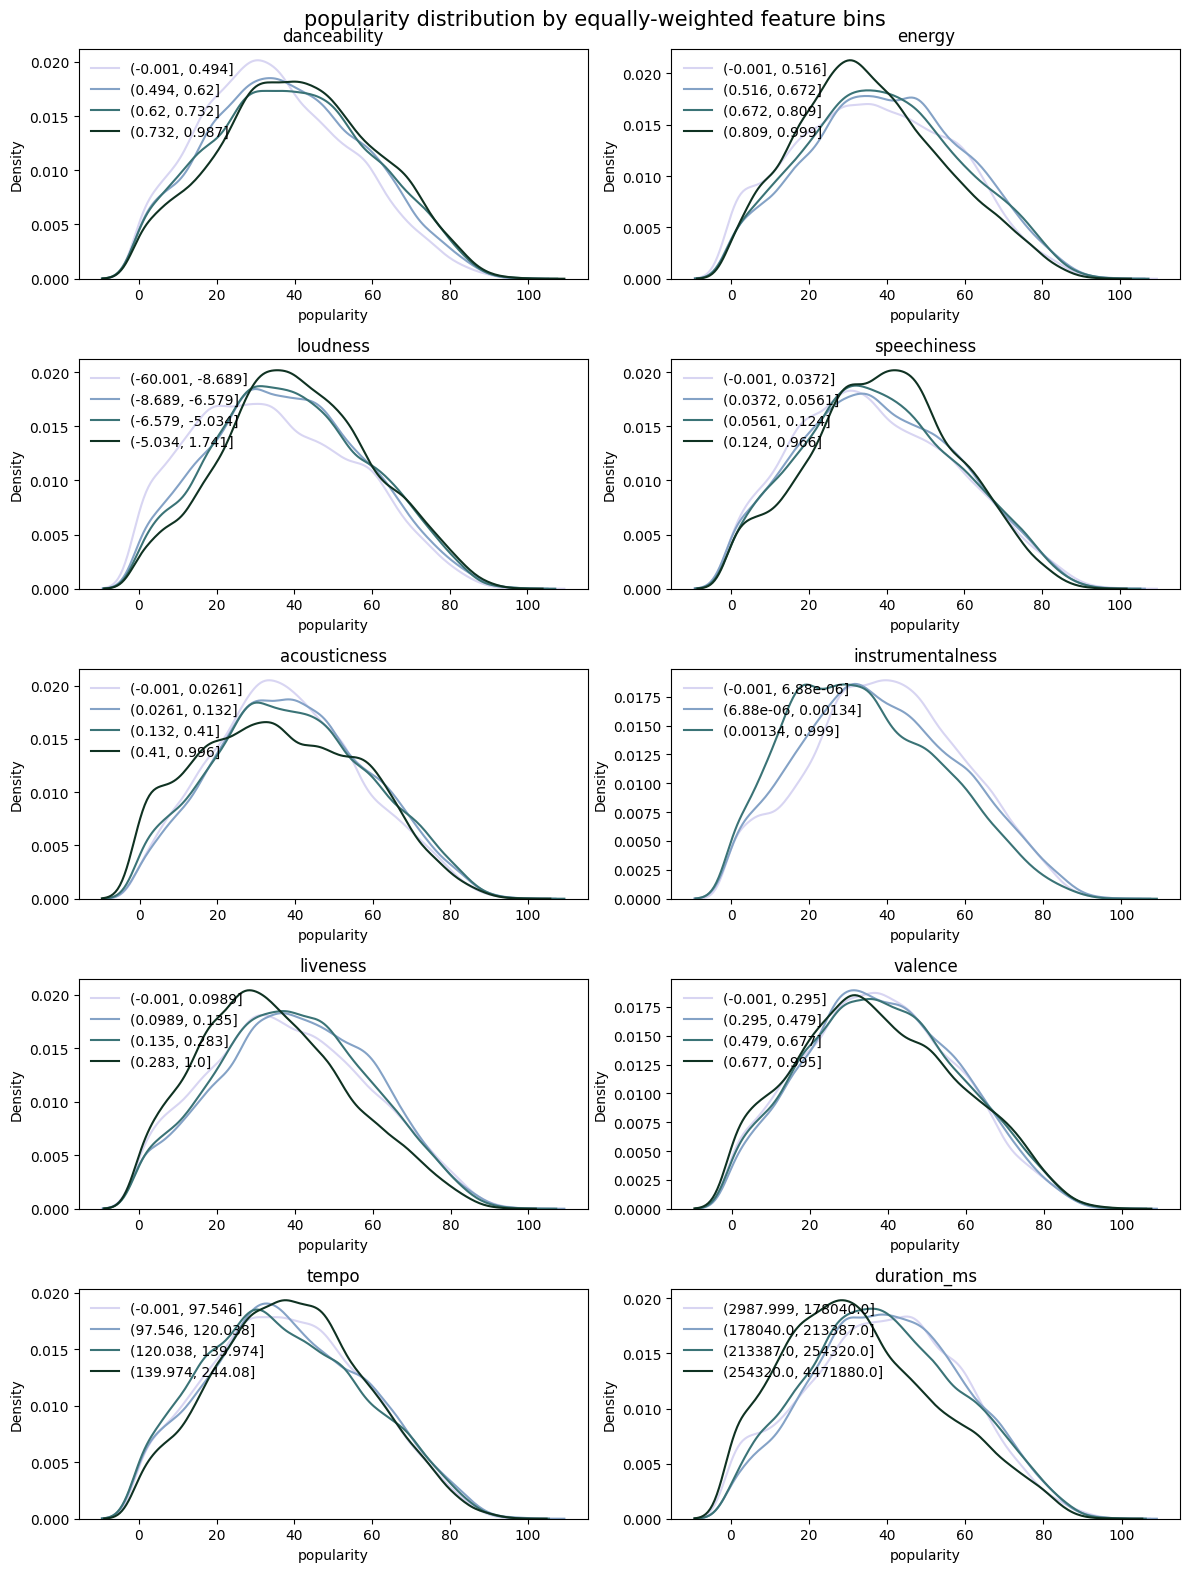

In [16]:
# Cut numeric predictors into 4 equally-weighted quantile bins.
tracks_bins = tracks[[TRGT_FEATURE] + numeric_preds].copy()
for feature in numeric_preds:
    tracks_bins[feature + '_bin'] = pd.qcut(tracks[feature], q = 4, duplicates = 'drop')

# Plot target feature distributions for 4-quantile cuts of each feature.
n_rows = 5
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize = (12, 16))
fig.suptitle(TRGT_FEATURE + ' distribution by equally-weighted feature bins', fontsize = 15)
line_colors = sns.cubehelix_palette(4, start = 2)
for i, feature in enumerate(numeric_preds):
    row, col = i // n_cols, i % n_cols
    ax = axes[row, col]
    col_num = 0
    for bin_label, group in tracks_bins.groupby(feature + '_bin'):
        sns.kdeplot(data = group, x = TRGT_FEATURE, color = line_colors[col_num], label = bin_label, ax = ax)
        col_num += 1
    ax.set_title(feature)
    ax.legend(loc = 'upper left', frameon = False)
for i in range(len(numeric_preds), n_rows * n_cols):    # hide empty subplots
    axes.flat[i].axis('off')
plt.tight_layout()
plt.show()

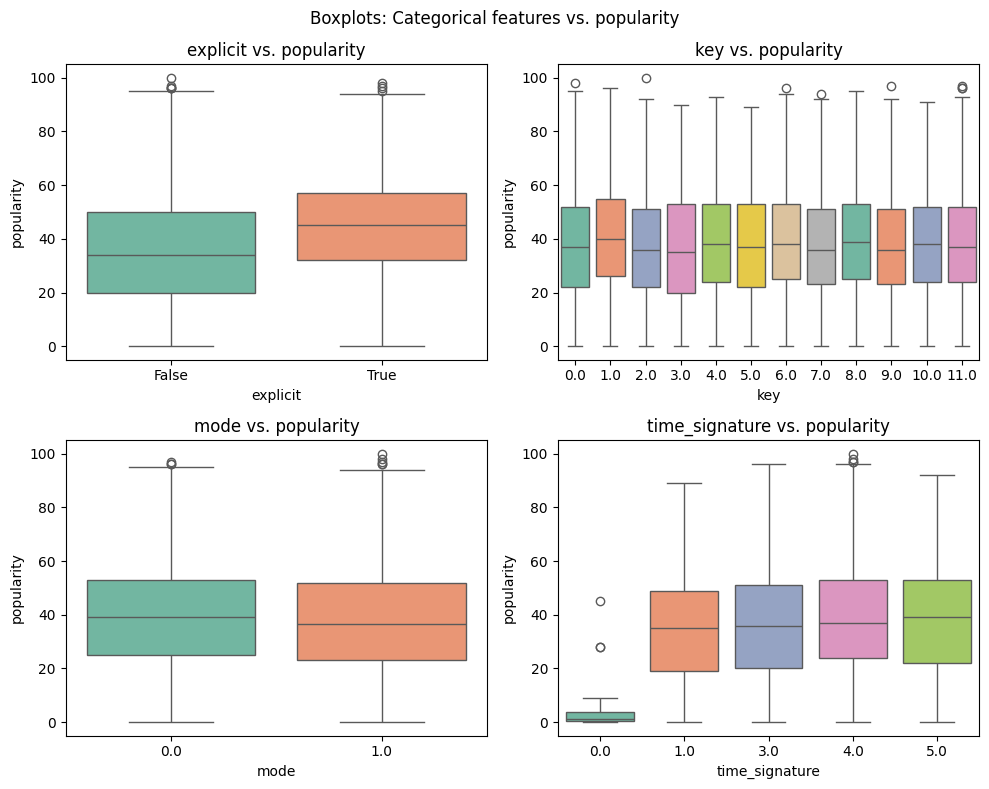

In [17]:
# Create subplots for each feature
ncols = 2
fig, axes = plt.subplots(2, ncols, figsize = (10, 8))
fig.suptitle('Boxplots: Categorical features vs. ' + TRGT_FEATURE)
for i, feature in enumerate(catg_preds):  # Exclude the target column
    row, col = divmod(i, ncols)
    sns.boxplot(
        data = tracks, x = feature, y = TRGT_FEATURE, 
        palette = 'Set2', ax = axes[row, col],
    )
    axes[row, col].set_title(feature + ' vs. ' + TRGT_FEATURE)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel(TRGT_FEATURE)
plt.tight_layout()
plt.show()

### Outliers

In [18]:
# Check outliers.
def check_outliers(
        col: str,
        tracks_data: pd.DataFrame = tracks,
):
    q1 = tracks_data[col].quantile(0.25)
    q3 = tracks_data[col].quantile(0.75)
    IQR_val = q3 - q1
    below_lim = tracks_data[col] < q1 - 1.5 * IQR_val
    above_lim = tracks_data[col] > q3 + 1.5 * IQR_val
    outliers = below_lim | above_lim
    num_outliers = outliers.sum()
    print('\n' + str(num_outliers), 'outliers in feature', col)
    if num_outliers:
        print('Outliers:')
        print(tracks.loc[outliers, col].value_counts().sort_index())
    else:
        col = None

    return col

In [19]:
cols_w_outliers = [check_outliers(col) for col in [TRGT_FEATURE] + numeric_preds]
cols_w_outliers = [col for col in cols_w_outliers if col != None]


8 outliers in feature popularity
Outliers:
popularity
96     4
97     2
98     1
100    1
Name: count, dtype: int64

124 outliers in feature danceability
Outliers:
danceability
0.00    26
0.06     1
0.06     1
0.06     1
0.07     1
0.07     1
0.07     1
0.07     1
0.07     1
0.07     1
0.08     1
0.08     1
0.08     1
0.08     1
0.08     1
0.08     1
0.08     1
0.08     1
0.09     1
0.09     2
0.09     3
0.09     1
0.09     1
0.09     1
0.09     1
0.10     1
0.10     1
0.10     3
0.10     1
0.10     2
0.10     2
0.10     1
0.11     1
0.11     1
0.11     2
0.11     1
0.11     5
0.11     2
0.11     2
0.12     1
0.12     1
0.12     4
0.12     1
0.12     2
0.12     1
0.12     3
0.12     4
0.12     1
0.12     2
0.12     2
0.13     2
0.13     1
0.13     6
0.13     5
0.13     1
0.13     1
0.14     6
0.14     2
Name: count, dtype: int64

450 outliers in feature energy
Outliers:
energy
0.00    2
0.00    1
0.00    1
0.00    1
0.00    1
       ..
0.07    3
0.08    2
0.08    1
0.08    3
0.08    2

In [20]:
# Check null value counts.
tracks.isnull().sum()

name                 0
id                   0
artist               0
artist_id            0
album                0
popularity           0
is_top_10            0
explicit             0
danceability        30
energy              30
key                 30
loudness            30
mode                30
speechiness         30
acousticness        30
instrumentalness    30
liveness            30
valence             30
tempo               30
duration_ms         30
time_signature      30
dtype: int64

## Data cleaning

### Remove nulls

In [21]:
# Get all rows with null.
rows_where_null = tracks.isnull().any(axis = 1)
tracks[rows_where_null]

,name,id,artist,artist_id,album,popularity,is_top_10,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
729,Valse Delle Vigne,3JSPIgK4QMCTSEXZCMRuPj,Nascondiglio,6ySvmMDgTOV3XTT6sgIovK,Valse Delle Vigne,64,1,False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4249,ISABELLA,36XrocrUkmem00MPm2kIst,¥$,4xPQFgDA5M2xa0ZGo5iIsv,VULTURES 2,21,0,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4296,EUROPA :(,6vh4S1z08AjGipGAEsV62e,Bad Bunny,4q3ewBCX7sLwd24euuV69X,nadie sabe lo que va a pasar mañana,19,0,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8130,ISABELLA,1dZMwxr9y1MQvyljOCUxw3,¥$,4xPQFgDA5M2xa0ZGo5iIsv,VULTURES 2,12,0,False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14371,The Element of Freedom (Intro),7JxiUfSIlnspU7TwJBj172,Alicia Keys,3DiDSECUqqY1AuBP8qtaIa,The Element Of Freedom,5,0,False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14503,Intro,7uhuCyUgZzq2teMExWBIZk,Snoop Dogg,7hJcb9fa4alzcOq3EaNPoG,Gangsta Grillz: I Still Got It,1,0,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21778,ISABELLA,1dZMwxr9y1MQvyljOCUxw3,¥$,4xPQFgDA5M2xa0ZGo5iIsv,VULTURES 2,11,0,False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22763,Vault Character,48eVBJaOkFchY0yUlhTSC4,Calvin Harris,7CajNmpbOovFoOoasH2HaY,I Created Disco,0,0,False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22907,"First Stop, Arizona - Dialogue",7A5uLkZbEOzHiAlhD2Hr2L,Cast,1ZfTuv9XlWT2CaIsIZPm52,A Star Is Born Soundtrack,11,1,False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22913,How Do You Hear It? - Dialogue,1UR9zquKVw87PBAl5b9PDH,Cast,1ZfTuv9XlWT2CaIsIZPm52,A Star Is Born Soundtrack,6,0,False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Few rows have null, can remove.
tracks = tracks[~rows_where_null].reset_index(drop = True)
print(tracks.isnull().sum().sum(), 'null values after removing rows.')

0 null values after removing rows.


### Encode categorical features
`mode` is already encoded

In [23]:
new_catg_cols = []

In [24]:
# Encode 'explicit'.
tracks['explicit'] = tracks['explicit'].astype('int32') # encode binary as int
tracks[['explicit']]

,explicit
0,1
1,1
2,1
3,1
4,1
...,...
44034,0
44035,0
44036,0
44037,0


In [25]:
# Replace single 'key' column with key name dummy columns.
major_keys = [
    'key_C',
    'key_C_sharp_D_flat',
    'key_D',
    'key_D_sharp_E_flat',
    'key_E',
    'key_F',
    'key_F_sharp_G_flat',
    'key_G',
    'key_G_sharp_A_flat',
    'key_A',
    'key_A_sharp_B_flat',
    'key_B'
]
key_replacements = dict(zip(range(len(major_keys)), major_keys))
tracks['key'] = tracks['key'].replace(key_replacements)
key_data = pd.get_dummies(tracks['key'], columns = major_keys).astype('int32')
tracks = pd.concat([tracks, key_data], axis = 1)    # add new dummy col key data
new_catg_cols += major_keys
drop_cols = ['key']
tracks[major_keys]

,key_C,key_C_sharp_D_flat,key_D,key_D_sharp_E_flat,key_E,key_F,key_F_sharp_G_flat,key_G,key_G_sharp_A_flat,key_A,key_A_sharp_B_flat,key_B
0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
44034,0,0,0,0,0,0,0,0,1,0,0,0
44035,0,0,0,0,0,0,0,0,0,0,0,1
44036,0,0,0,0,0,0,0,0,0,0,1,0
44037,0,0,0,0,0,0,1,0,0,0,0,0


In [26]:
# Check alignment with previous column 'key' value counts.
vals_match = [(tracks[col] == 1).sum() == (tracks['key'] == col).sum() for col in major_keys]
all(vals_match)

True

In [27]:
# # Replace single key column with key name dummy columns.
# time_sig_vals = tracks['time_signature'].unique()
# time_sig_vals = sorted([str(int(v)) for v in time_sig_vals if v == v])
# time_sig_cols = ['time_signature_' + v for v in time_sig_vals]
# time_sig_data = pd.get_dummies(tracks['time_signature']).astype('int32')
# time_sig_data.columns = time_sig_cols
# tracks = pd.concat([tracks, time_sig_data], axis = 1)    # add new dummy col data
# new_catg_cols += time_sig_cols
# drop_cols += ['time_signature']
# tracks[time_sig_cols]

In [28]:
_ = [check_outliers(col, tracks) for col in new_catg_cols]


5149 outliers in feature key_C
Outliers:
key_C
1    5149
Name: count, dtype: int64

4997 outliers in feature key_C_sharp_D_flat
Outliers:
key_C_sharp_D_flat
1    4997
Name: count, dtype: int64

4255 outliers in feature key_D
Outliers:
key_D
1    4255
Name: count, dtype: int64

1332 outliers in feature key_D_sharp_E_flat
Outliers:
key_D_sharp_E_flat
1    1332
Name: count, dtype: int64

3164 outliers in feature key_E
Outliers:
key_E
1    3164
Name: count, dtype: int64

3657 outliers in feature key_F
Outliers:
key_F
1    3657
Name: count, dtype: int64

2982 outliers in feature key_F_sharp_G_flat
Outliers:
key_F_sharp_G_flat
1    2982
Name: count, dtype: int64

4706 outliers in feature key_G
Outliers:
key_G
1    4706
Name: count, dtype: int64

3041 outliers in feature key_G_sharp_A_flat
Outliers:
key_G_sharp_A_flat
1    3041
Name: count, dtype: int64

4201 outliers in feature key_A
Outliers:
key_A
1    4201
Name: count, dtype: int64

2989 outliers in feature key_A_sharp_B_flat
Outliers:
k

The key features are low-variance. Remove for now. Could try some grouping of "similar" keys?

### Low variance features and outliers

In [29]:
# Remove low-variance feature(s).
drop_cols += major_keys + ['time_signature']#[c for c in time_sig_cols if c != 'time_signature_4']
tracks = tracks.drop(columns = drop_cols)
[catg_preds.remove(col) for col in drop_cols if col in catg_preds]
[numeric_preds.remove(col) for col in drop_cols if col in numeric_preds]
[preds.remove(col) for col in drop_cols if col in preds]
_ = [cols_w_outliers.remove(col) for col in drop_cols if col in cols_w_outliers]

In [30]:
# Cap outliers.
ws = Winsorizer(capping_method = 'iqr', tail = 'both', fold = 'auto', variables = cols_w_outliers)
ws.fit(tracks[cols_w_outliers])
tracks[cols_w_outliers] = ws.transform(tracks[cols_w_outliers])
cols_w_outliers = [check_outliers(col, tracks) for col in cols_w_outliers]


0 outliers in feature popularity

0 outliers in feature danceability

0 outliers in feature energy

0 outliers in feature loudness

0 outliers in feature speechiness

0 outliers in feature acousticness

0 outliers in feature instrumentalness

0 outliers in feature liveness

0 outliers in feature tempo

0 outliers in feature duration_ms


### Standardization/normalization

In [31]:
# scaler = StandardScaler() 
# tracks[numeric_preds] = scaler.fit_transform(tracks[numeric_preds])
# tracks.head()

# Feature selection

## Split train/test from holdout

In [32]:
# Set split column.
tracks['TEST'] = np.random.randint(1, 6, size = tracks.shape[0])
train_idx, val_idx = tracks['TEST'].isin(range(1, NUM_FOLDS)), tracks['TEST'] == NUM_FOLDS
tracks_no_holdout = tracks.loc[train_idx]
cv_splits_no_holdout = PredefinedSplit(tracks_no_holdout['TEST'])  # only 1-4
# cv_splits_with_holdout = PredefinedSplit(tracks['TEST'])  # 1-5

In [33]:
def split_train_test_val(
        all_data: pd.DataFrame,
):

    # Distinguish predictors and response.
    X, y = all_data.drop(columns = NON_PREDICTORS), all_data[TRGT_FEATURE]
    X_cv, X_val = X.loc[train_idx], X.loc[val_idx]
    y_cv, y_val = y.loc[train_idx], y.loc[val_idx]

    return X_cv, X_val, y_cv, y_val

In [34]:
# Split data.
X_cv, X_val, y_cv, y_val = split_train_test_val(tracks)
pd.concat([tracks_no_holdout['TEST'], X_cv], axis = 1)

,TEST,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
1,1,1,0.48,0.61,-7.04,1.00,0.25,0.05,0.00,0.31,0.30,90.03,255653.00
2,4,1,0.50,0.68,-5.65,1.00,0.25,0.01,0.00,0.40,0.36,81.28,309693.00
3,4,1,0.22,0.50,-8.03,1.00,0.04,0.13,0.00,0.11,0.31,187.31,265480.00
4,4,1,0.56,0.89,-8.08,1.00,0.25,0.13,0.00,0.56,0.54,119.91,247293.00
5,2,1,0.35,0.84,-6.46,0.00,0.05,0.00,0.00,0.12,0.47,72.29,230067.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44034,2,0,0.48,0.65,-5.82,0.00,0.05,0.25,0.00,0.07,0.20,109.45,250776.00
44035,1,0,0.49,0.68,-4.98,0.00,0.04,0.11,0.00,0.25,0.38,132.16,208051.00
44036,3,0,0.49,0.69,-4.99,0.00,0.05,0.07,0.00,0.09,0.32,123.07,222912.00
44037,4,0,0.56,0.69,-2.47,0.00,0.25,0.47,0.00,0.10,0.72,86.13,157514.00


## Feature correlation

In [35]:
# Check correlation to response.
feature_correlations = pd.concat([y_cv, X_cv], axis = 1).corr()
correlations_to_response = abs(feature_correlations[TRGT_FEATURE])
correlations_to_response = correlations_to_response.sort_values(ascending = False)[1:]  # remove target
correlations_to_response

explicit           0.21
loudness           0.13
liveness           0.12
danceability       0.12
instrumentalness   0.12
duration_ms        0.10
acousticness       0.06
mode               0.04
speechiness        0.02
tempo              0.01
energy             0.01
valence            0.01
Name: popularity, dtype: float64

In [36]:
# Reorder features according to correlations to response ("importance").
preds = correlations_to_response.index.tolist()
X_cv, X_val = X_cv[preds], X_val[preds]

In [37]:
# Check largest feature correlations (get 2nd largest due to correlation to itself).
feature_correlations = feature_correlations.abs()
max_row_corrs = feature_correlations.apply(lambda row: row.nlargest(2).iat[-1], axis = 1)
max_col_corrs = feature_correlations.apply(lambda col: col.nlargest(2).iat[-1], axis = 0)
max_corrs = pd.concat([max_row_corrs, max_col_corrs], axis = 1)
max_corrs = max_corrs.max(axis = 1)
max_corrs.sort_values(ascending = False)

loudness           0.72
energy             0.72
acousticness       0.65
speechiness        0.48
explicit           0.48
valence            0.42
danceability       0.42
instrumentalness   0.24
popularity         0.21
liveness           0.20
tempo              0.16
duration_ms        0.14
mode               0.12
dtype: float64

In [38]:
# For features with correlations of 0.7 or greater, drop the less important.
# Between 'loudness' and 'energy', drop 'energy' for now.
tracks = tracks.drop(columns = ['energy'])
tracks_no_holdout = tracks_no_holdout.drop(columns = ['energy'])
X_cv, X_val, y_cv, y_val = split_train_test_val(tracks)

Feature correlations can approach high values (e.g. `energy` and `loudness`), but the values are not high enough to warrant removing the features due to bias. If anything, remove `energy` at this point. Proceed with all features for now though.

## Feature importance with SHAP

In [39]:
# P-values.
X_sm = sm.add_constant(X_cv)
sm_model = sm.OLS(y_cv, X_sm).fit()
p_vals = sm_model.pvalues.sort_values()
p_vals.apply(lambda x: '%.5f' % x)

const               0.00000
explicit            0.00000
liveness            0.00000
speechiness         0.00000
loudness            0.00000
duration_ms         0.00000
instrumentalness    0.00000
valence             0.00000
danceability        0.00000
mode                0.00004
tempo               0.13357
acousticness        0.28883
dtype: object

### Helper functions

In [40]:
def get_XGB_model(
        cv: PredefinedSplit,
        random_state: int = RANDOM_STATE,
        is_SHAP_call: bool = False,
):

    # Make XGBoost model.
    rmse_scorer = make_scorer(rmse, greater_is_better = False)
    if is_SHAP_call:
        params = {}
    else:
        params = {
            'reg_alpha': [0, 1, 3, 5],
            'reg_lambda': [0, 1, 3, 5],
        }
    model = GridSearchCV(
        estimator = XGBRegressor(random_state = random_state),
        param_grid = params, cv = cv,
        scoring = rmse_scorer,
    )

    return model

In [41]:
def get_SHAP_vals(
        X_in: pd.DataFrame,
        y_in: pd.Series,
        cv: PredefinedSplit,
        random_state: int = RANDOM_STATE,
):
    
    # Make XGBoost model.
    model = get_XGB_model(cv, random_state, is_SHAP_call = True)
    model.fit(X_in, y_in)
    model = model.best_estimator_
    # Also get SHAP values of the model.
    shap_vals = shap.TreeExplainer(model).shap_values(X = X_in, check_additivity = False)
    shap_vals = pd.DataFrame(shap_vals, columns = X_in.columns)

    return shap_vals

In [42]:
def SHAP_plot(
        shap_vals: pd.DataFrame,
        X_in: pd.DataFrame,
):

    # Get correlation coefficients of SHAP values and train data.
    X_in = X_in.reset_index(drop = True)
    iter_pred = X_in.columns
    corr_list = [
        np.corrcoef(
            shap_vals.loc[~X_in[i].isnull()].loc[:, i],
            X_in.loc[~X_in[i].isnull()].loc[:, i]
        )[1][0]
        for i in iter_pred
    ]
    # Organize features and correlation values.
    correlations = pd.concat([pd.Series(iter_pred), pd.Series(corr_list)], axis = 1).fillna(0)
    correlations.columns = ['Feature', 'Correlation']
    # Notate which features are positively/negatively correlated.
    correlations['Sign'] = np.where(correlations['Correlation'] < 0, 'red', 'blue')
    shap_vals = pd.DataFrame(np.abs(shap_vals).mean()).reset_index()
    shap_vals.columns = ['Feature', 'SHAP_abs_val']
    
    # Do SHAP plot.
    shap_vals = shap_vals.merge(correlations, left_on = 'Feature', right_on = 'Feature', how = 'inner')
    shap_vals = shap_vals.sort_values(by = 'SHAP_abs_val', ascending = True)
    ax = shap_vals.plot.barh(
        x = 'Feature',
        y = 'SHAP_abs_val',
        color = shap_vals['Sign'],
        legend = False,
        figsize = (6, X_in.shape[1] * 0.3),
    )
    ax.set_xlabel('SHAP Value')
    plt.show()

    return shap_vals.sort_values('SHAP_abs_val', ascending = False)

In [43]:
def do_val_actual_vs_pred_plot(
        val_pred: dict,
):
    
    # Get maximum and minimum to set axis limits.
    all_actual = np.concatenate([df['actual'].values for df in val_pred.values()])
    all_pred = np.concatenate([df['predicted'].values for df in val_pred.values()])
    overall_min = min(all_actual.min(), all_pred.min())
    overall_max = max(all_actual.max(), all_pred.max())
    # Do scatterplot of actual vs. predicted values for validation data.
    nrows = math.ceil(len(val_pred) / 3)
    fig, axes = plt.subplots(nrows = nrows, ncols = 3, figsize = (10, 10))
    fig.suptitle('Validation Actual vs. Predicted', fontsize = 12)
    axes = axes.flatten()
    for ax, (feat_list_num, df) in zip(axes, val_pred.items()):
        ax.scatter(df['actual'], df['predicted'], s = 10, c = 'crimson')
        ax.plot([overall_min, overall_max], [overall_min, overall_max], 'b-')
        ax.set_xlim(overall_min, overall_max)
        ax.set_ylim(overall_min, overall_max)
        ax.set_title('feat_list_' + str(feat_list_num), fontsize = 10)
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
    plt.tight_layout()
    plt.axis('equal')
    plt.show()

    return

In [44]:
def do_test_actual_vs_pred_plot(
        test_preds: dict,
        do_plots_per_fold: bool = False,
):

    if do_plots_per_fold:
        # Plot actual vs. predicted values of each test fold.
        fig, axs = plt.subplots(2, 2, figsize = (7, 5))
        for idx in test_preds:
            actual, pred = test_preds[idx]['actual'], test_preds[idx]['predicted']
            row, col = divmod(idx, 2)
            ax = axs[row, col]
            ax.scatter(x = actual, y = pred, c = 'crimson')
            p1 = max(pred.max(), actual.max())
            p2 = min(pred.min(), actual.min())
            ax.plot([p1, p2], [p1, p2], 'b-')   # perfect prediction line
            title = f'Test Fold {idx+1} Actual vs. Predicted {TRGT_FEATURE}'
            ax.set_title(title, fontsize = 9)
            ax.set_xlabel('Actual ' + TRGT_FEATURE, fontsize = 8)
            ax.set_ylabel('Predicted ' + TRGT_FEATURE, fontsize = 8)
        plt.tight_layout()
        plt.show()

    # Do 1 plot for all test folds.
    concat_dt = [test_preds[k] for k in test_preds]
    test_preds_concat = pd.concat(concat_dt, ignore_index = True)
    fig, ax = plt.subplots(figsize = (6, 4))
    actual, pred = test_preds_concat['actual'], test_preds_concat['predicted']
    ax.scatter(x = actual, y = pred, c = 'crimson')
    p1 = max(pred.max(), actual.max())
    p2 = min(pred.min(), actual.min())
    ax.plot([p1, p2], [p1, p2], 'b-')   # perfect prediction line
    ax.set_title(f'Test Folds 1-4 Actual vs. Predicted {TRGT_FEATURE}', fontsize = 12)
    ax.set_xlabel('Actual ' + TRGT_FEATURE, fontsize = 10)
    ax.set_ylabel('Predicted ' + TRGT_FEATURE, fontsize = 10)
    plt.tight_layout()
    plt.show()

    return

In [45]:
def do_test_pred_err_plot(
        test_pred: dict[pd.DataFrame],
        test_pred_errs: list,
        do_plots_per_fold: bool = False,
):

    # Calculate standard deviation or error for each fold
    pred_errors = {}
    for fold_name, df in test_pred.items():
        pred_errors[fold_name] = df['actual'] - df['predicted']

    if do_plots_per_fold:
        # Plot standard deviation or error for each fold
        fig, axes = plt.subplots(2, 2, figsize=(7, 5))
        for idx, (fold_name, ax) in enumerate(zip(pred_errors.keys(), axes.flatten())):
            sns.histplot(pred_errors[fold_name], bins = 25, kde = True, ax = ax)
            ax.set_title(f'Test Fold {idx+1} Error Distribution', fontsize = 9)
            ax.set_xlabel('Error', fontsize = 8)
            ax.set_ylabel('Count', fontsize = 8)
            ax.axvline(x = 0, color = 'red', linestyle = '--')
            ax.axvline(x = test_pred_errs[idx], color = 'blue', linestyle = ':')
            ax.axvline(x = 2 * test_pred_errs[idx], color = 'cornflowerblue', linestyle = ':')
            ax.axvline(x = -test_pred_errs[idx], color = 'blue', linestyle = ':')
            ax.axvline(x = 2 * -test_pred_errs[idx], color = 'cornflowerblue', linestyle = ':')
            ax.set_xlim(min(pred_errors[fold_name]), max(pred_errors[fold_name]))
            ax.set_ylim(0, test_pred[0].shape[0] / 8)
        plt.tight_layout()
        plt.show()

    # Do 1 plot for all test folds.
    concat_dt = [pred_errors[k] for k in pred_errors]
    pred_errors_concat = pd.concat(concat_dt, ignore_index = True)
    avg_pred_err = sum(test_pred_errs) / len(test_pred_errs)
    fig, ax = plt.subplots(figsize = (6, 4))
    sns.histplot(pred_errors_concat, bins = 25, kde = True, ax = ax, color = 'cornflowerblue')
    ax.set_title(f'Test Folds 1-4 Error Distribution', fontsize = 12)
    ax.set_xlabel('Prediction Error', fontsize = 10)
    ax.set_ylabel('Count', fontsize = 10)
    ax.axvline(x = 0, color = 'red', linestyle = '--')
    ax.axvline(x = avg_pred_err, color = 'blue', linestyle = ':')
    ax.axvline(x = 2 * avg_pred_err, color = 'cornflowerblue', linestyle = ':')
    ax.axvline(x = -avg_pred_err, color = 'blue', linestyle = ':')
    ax.axvline(x = 2 * -avg_pred_err, color = 'cornflowerblue', linestyle = ':')
    ax.set_xlim(pred_errors_concat.min(), pred_errors_concat.max())
    ax.set_ylim(0, test_pred[0].shape[0] / (8 / 4))
    plt.tight_layout()
    plt.show()

    return

In [46]:
def do_val_pred_error_boxplot(
        all_test_preds: dict[pd.DataFrame],
):

    # Set dataframe of absolute errors of test predictions.
    abs_errors = pd.DataFrame()
    for key in all_test_preds:
        err = all_test_preds[key]['actual'] - all_test_preds[key]['predicted']
        abs_errors['feat_list_' + str(key)] = err.abs()

    # Create a single plot with all boxplots stacked.
    plt.figure(figsize = (8, 6))
    sns.boxplot(data = abs_errors, orient = 'h')
    plt.title('Validation Prediction Error Distribution for Feature Lists')
    plt.xlabel('Absolute Prediction Error')
    plt.ylabel('Feature List Name')
    plt.xlim(0, 50)
    plt.tight_layout()
    plt.show()

In [47]:
def do_model_metrics(
        X_in: pd.DataFrame,
        y_in: pd.DataFrame,
        feat_list_num: int,
):

    # Model using training data.
    model = get_XGB_model(cv_splits_no_holdout)
    model.fit(X_in, y_in)
    
    # Get test metrics.
    avg_test_RMSE = 0
    iter_splits = range(NUM_TRAIN_SPLITS)
    test_RMSE_keys = ['split' + str(n) + '_test_score' for n in iter_splits]
    for key in test_RMSE_keys:
        avg_test_RMSE -= float(model.cv_results_[key][model.best_index_])
    avg_test_RMSE /= NUM_TRAIN_SPLITS

    # Get validation predictions and metrics.
    model = model.best_estimator_
    val_pred = pd.Series(model.predict(X_val[X_in.columns]))
    y_val_tmp = y_val.reset_index(drop = True)
    val_actual_pred = pd.concat([y_val_tmp, val_pred], axis = 1)
    val_actual_pred.columns = ['actual', 'predicted']
    val_RMSE = float(rmse(y_val_tmp, val_pred))
    val_pred_err = np.mean((y_val_tmp - val_pred).abs())

    # Set metrics for return.
    cols = ['feat_list_num', 'avg_test_RMSE', 'val_RMSE', 'val_pred_err']
    metrics = pd.DataFrame(columns = cols)
    metrics.loc[0] = [feat_list_num, avg_test_RMSE, val_RMSE, val_pred_err]

    return model, metrics, val_actual_pred

In [48]:
def get_random_prediction_errors(
        y_in: pd.Series = y_cv,
):

    # Model using training data.
    y_val_tmp = y_val.reset_index(drop = True)
    y_in_tmp = y_in.reset_index(drop = True)
    num_samples = len(y_val_tmp)
    static_pred = pd.Series([np.mean(y_in_tmp)] * num_samples)
    # rand_pred = pd.Series(random.choices(y_in_tmp, k = num_samples))
    static_pred_RMSE = round(float(rmse(y_val_tmp, static_pred)), 2)
    static_pred_mean_err = round(float(np.mean((y_val_tmp - static_pred).abs())), 2)
    rand_pred_mean_errors = {
        'val_static_pred_RMSE': static_pred_RMSE,
        'val_static_pred_mean_err': static_pred_mean_err,
        # 'val_rand_pred_RMSE': rmse(y_val_tmp, rand_pred),
        # 'val_rand_pred_mean_err': np.mean((y_val_tmp - rand_pred).abs()),
    }
    
    return rand_pred_mean_errors

### Do SHAP and metrics

In [50]:
all_models = {}
all_metrics = pd.DataFrame()
all_val_preds = {}

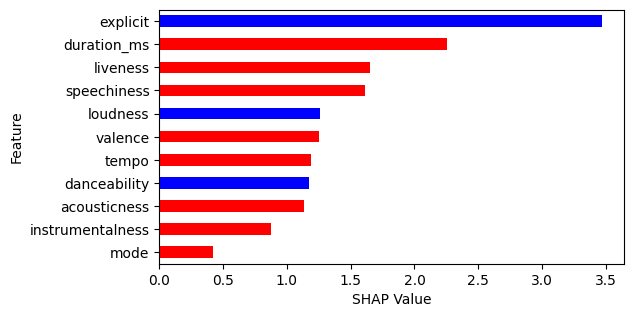

,feat_list_num,avg_test_RMSE,val_RMSE,val_pred_err
0,0.00,18.74,18.84,15.26


In [51]:
# Generate SHAP values for a model with all predictors.
feat_list_num = 0
X_in = X_cv.copy()
shap_vals = get_SHAP_vals(X_in, y_cv, cv_splits_no_holdout)
shap_df = SHAP_plot(shap_vals, X_in)

# Do plots and get model metrics.
model, metrics_tmp, val_pred = do_model_metrics(X_in, y_cv, feat_list_num)
all_models[feat_list_num] = model
all_val_preds[feat_list_num] = val_pred
all_metrics = pd.concat([all_metrics, metrics_tmp], ignore_index = True)

all_metrics

In [52]:
get_random_prediction_errors()

{'val_static_pred_RMSE': 19.95, 'val_static_pred_mean_err': 16.52}

Only slightly better than guessing the average.

In [53]:
# Set feature lists based on importance.
# Auto-lists using SHAP value output.
feat_list_ordered = shap_df['Feature'].tolist()
num_feat_lists = 8
feature_lists = {i+1: feat_list_ordered[:i+1] for i in range(num_feat_lists)}

Feature list #1: ['explicit']


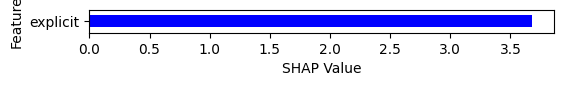

Feature list #2: ['explicit', 'duration_ms']


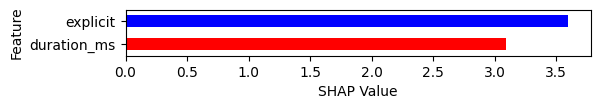

Feature list #3: ['explicit', 'duration_ms', 'liveness']


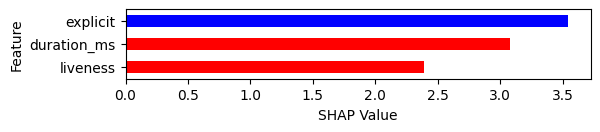

Feature list #4: ['explicit', 'duration_ms', 'liveness', 'speechiness']


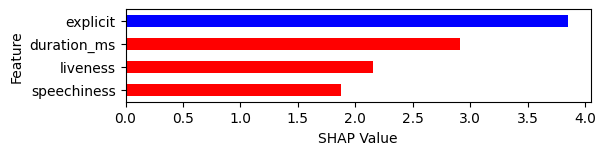

Feature list #5: ['explicit', 'duration_ms', 'liveness', 'speechiness', 'loudness']


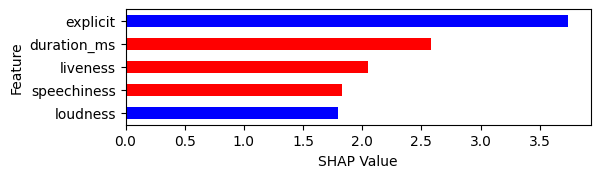

Feature list #6: ['explicit', 'duration_ms', 'liveness', 'speechiness', 'loudness', 'valence']


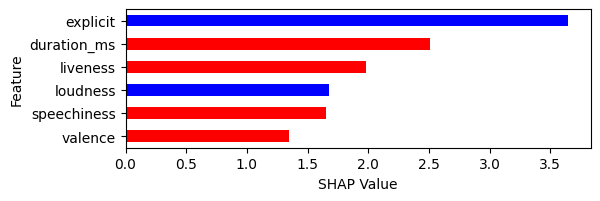

Feature list #7: ['explicit', 'duration_ms', 'liveness', 'speechiness', 'loudness', 'valence', 'tempo']


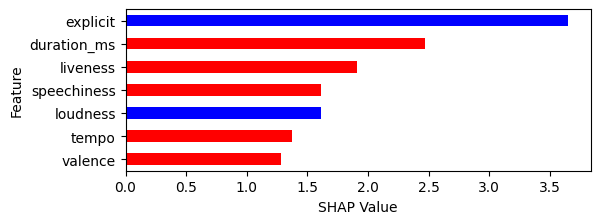

Feature list #8: ['explicit', 'duration_ms', 'liveness', 'speechiness', 'loudness', 'valence', 'tempo', 'danceability']


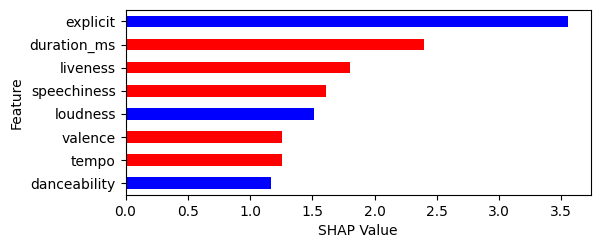

,feat_list_num,avg_test_RMSE,val_RMSE,val_pred_err
0,0,18.74,18.84,15.26
1,1,19.39,19.59,16.07
2,2,19.10,19.21,15.72
3,3,19.10,19.23,15.68
4,4,19.10,19.15,15.57
5,5,19.00,19.10,15.51
6,6,18.96,18.98,15.37
7,7,18.89,18.93,15.35
8,8,18.85,18.85,15.31


In [54]:
# Generate SHAP values for models with different feature lists.
for feat_list_num in feature_lists:
    features = feature_lists[feat_list_num]
    print('Feature list #' + str(feat_list_num) + ':', features)
    X_in = X_cv[features]
    shap_vals = get_SHAP_vals(X_in, y_cv, cv_splits_no_holdout)
    shap_df = SHAP_plot(shap_vals, X_in)
    # Do plots and get model metrics.
    model, metrics_tmp, val_pred = do_model_metrics(X_in, y_cv, feat_list_num)
    all_models[feat_list_num] = model
    all_val_preds[feat_list_num] = val_pred
    all_metrics = pd.concat([all_metrics, metrics_tmp], ignore_index = True)

all_metrics['feat_list_num'] = all_metrics['feat_list_num'].astype(int)
all_metrics

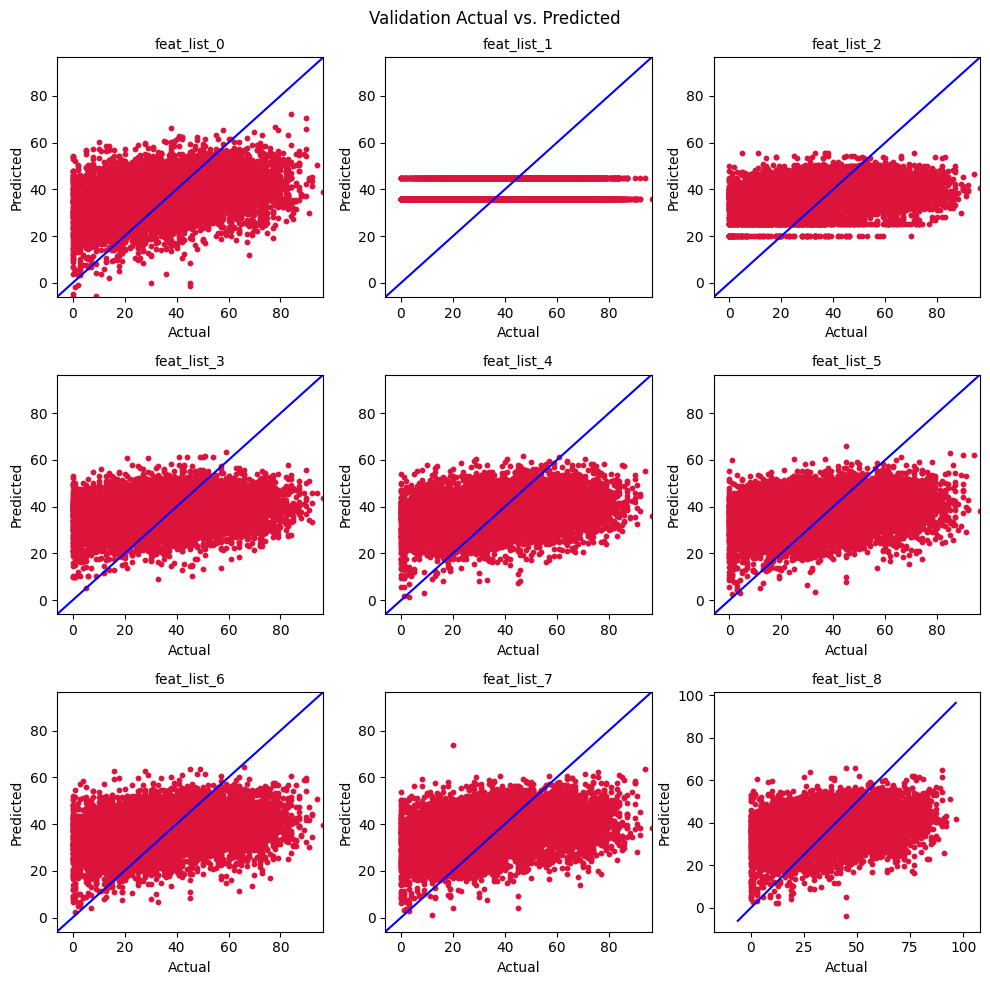

In [55]:
do_val_actual_vs_pred_plot(all_val_preds)

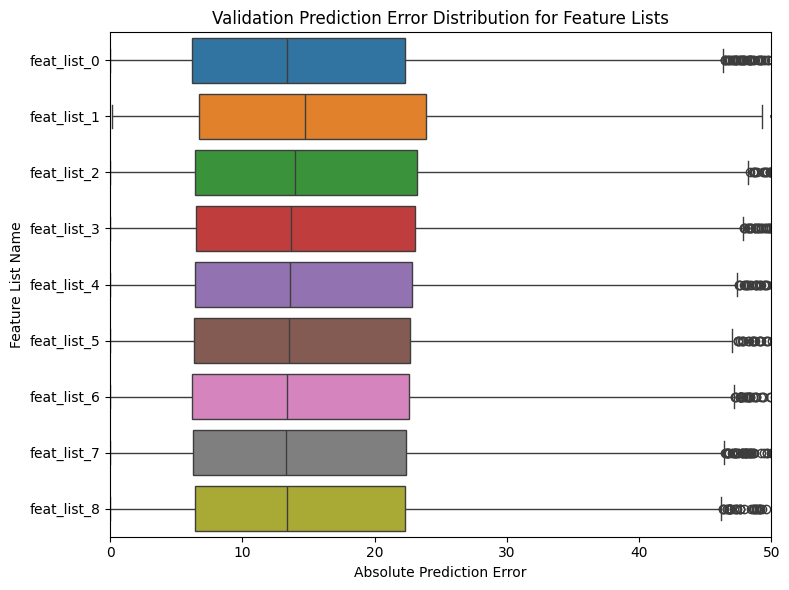

In [56]:
do_val_pred_error_boxplot(all_val_preds)

### Conclusions

Features have low impact on the predictions of a track's `popularity`. RMSE sees only slight improvements as we add more features, and mean prediction error on the validation shows a similar trend.

Feature impacts:
- `explicit` is the most impactful feature. Explicit tracks tend to be more popular than tracks without the explicit label.
- `duration_ms` confirms a trend that has played out slowly since Western popular music's meteoric rise, and has only exacerbated with the impact of social media (TikTok) on recent listening habits: Shorter songs will prevail in terms of popularity.
- `liveness` shows that the more your song sounds like a live performance, the less popular it is likely to be. Live albums are becoming less and less common due to many reasons, not the least of which are mass migrations of listenership to YouTube videos of these live performances.
- `speechiness` tells us that more speech-ey sounding tracks are likely to be less popular. Thus, tracks with more sonic dominance tend toward higher popularity.
- `loudness` says that louder tracks are the way toward popularity. The non-positive values of this feature are not of importance solely in regards to the impact the feature has, since lower values still indicate quieter tracks.
- `tempo` indicates that slower tracks tend to be more popular.
- `danceability` tells us that more danceable tracks tend towards higher popularity values. Makes enough sense, also due to social media's content appetite for tracks with popular dances choreographed.
- `valence` interestingly indicates that more negative-sounding tracks will be more popular. However, this is the least impactful feature used in this process, so we may take the information of this and a few of the latter features with a grain of salt.

## Save data

In [57]:
if EXPORT_DATA:
    # Export tracks data for modeling.
    tracks_export_path = os.path.join(TRACKS_LOC, 'modeling_tracks.csv')
    tracks.to_csv(tracks_export_path, index = False)
    # Export feature lists.
    with open(os.path.join(DATA_LOC, 'Feature Lists', 'feature_lists.p'), 'wb') as fp:
        pickle.dump(feature_lists, fp, protocol = pickle.HIGHEST_PROTOCOL)